In [1]:
import os
os.chdir("../../")
import pandas as pd

import spacy
from nltk.corpus import stopwords
from src.text.epu import *
from src.text.utils import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tiktoken

In [2]:
folder = os.getcwd() + "/data/text/abc_au/"
file_lists = [folder + file for file in os.listdir(folder) if "news" in file]

news_df = pd.DataFrame()
for file in file_lists:
    df = pd.read_csv(file).drop("Unnamed: 0", axis=1)
    if news_df.empty:
        news_df = df
    else:
        news_df = pd.concat([news_df, df], axis=0).reset_index(drop=True)
        
news_df = news_df.dropna().reset_index(drop=True)

In [3]:
econ_list = [
    'economy', 'economic', 'economics', 'business', 'commerce', 'finance',
    'industry', "assistance", "science and technology", "trade", "mining and metals industry"
]
news_df["econ"] = news_df["tags"].str.lower().apply(is_in_word_list, terms=econ_list)

In [4]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
spacy_stopwords = list(nlp.Defaults.stop_words)

nltk_stopwords = stopwords.words("english")
nltk_unique = [sw for sw in nltk_stopwords if sw not in spacy_stopwords]
spacy_stopwords.extend(nltk_unique)

In [5]:
from src.text.utils import *
data = news_df.news.values.tolist()
data_words = list(sent_to_words(data))

bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[data_words], min_count=20, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_preprocessed = preprocess_text(data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

Stopwords has been done.


In [9]:
news_df["texts"] = texts_preprocessed
news_df["texts"] = news_df["texts"].apply(lambda x: " ".join(i for i in x))

## Glove

In [7]:
import gensim.downloader
# Download the "glove-twitter-25" embeddings
glove_vectors = gensim.downloader.load('word2vec-google-news-300')

In [10]:
def get_average_word_vectors(text, model):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

text_embeddings = [get_average_word_vectors(text, glove_vectors) for text in news_df["texts"]]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    text_embeddings,   
    news_df['econ'].astype(int), 
    test_size=0.1, 
    random_state=42,  
    shuffle=True)   

In [28]:
clf = XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1164
           1       0.88      0.66      0.75       208

    accuracy                           0.93      1372
   macro avg       0.91      0.82      0.86      1372
weighted avg       0.93      0.93      0.93      1372



In [21]:
models = [
    RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42),
    LinearSVC(random_state=42),
    LogisticRegression(solver='liblinear', C=1, penalty='l2', random_state=42),
    XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)
]

scoring = ['accuracy', 'f1_macro', 'recall', 'precision']

for model in models:
    model_name = model.__class__.__name__
    result = cross_validate(model,
                            X_train,
                            y_train,
                            cv=5,
                            scoring=scoring)
    print(
        "%s: Mean Accuracy = %.2f%%; Mean F1-macro = %.2f%%; Mean recall-macro = %.2f%%; Mean precision-macro = %.2f%%"
        % (model_name, result['test_accuracy'].mean() * 100,
           result['test_f1_macro'].mean() * 100, result['test_recall'].mean() *
           100, result['test_precision'].mean() * 100))

RandomForestClassifier: Mean Accuracy = 86.58%; Mean F1-macro = 58.19%; Mean recall-macro = 13.85%; Mean precision-macro = 83.43%


/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  war

LinearSVC: Mean Accuracy = 88.79%; Mean F1-macro = 73.16%; Mean recall-macro = 41.38%; Mean precision-macro = 72.53%
LogisticRegression: Mean Accuracy = 88.27%; Mean F1-macro = 70.81%; Mean recall-macro = 36.23%; Mean precision-macro = 72.23%
XGBClassifier: Mean Accuracy = 92.60%; Mean F1-macro = 84.00%; Mean recall-macro = 63.87%; Mean precision-macro = 83.24%


In [30]:
sib_files = [
    os.getcwd() + "/data/text/rnz/solomon_islands_rnz_news.csv",
    os.getcwd() + "/data/text/abc_au/solomon_islands_abc_news.csv",
]

sib_folder = os.getcwd() + "/data/text/solomon_islands/"
sib_files.extend([sib_folder+file for file in os.listdir(sib_folder) if "news" in file])

In [31]:
sib = pd.DataFrame()
for file in sib_files:
    temp = pd.read_csv(file).drop("Unnamed: 0", axis=1)
    if sib.empty:
        sib = temp
    else:
        sib = pd.concat([sib, temp], axis=0).reset_index(drop=True)

sib = sib[sib.news.isna() != True].reset_index(drop=True)

In [32]:
sib_data = sib.news.values.tolist()
sib_data_words = list(sent_to_words(sib_data))

bigram = gensim.models.Phrases(sib_data_words, min_count=20, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[sib_data_words], min_count=20, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

sib_texts = preprocess_text(sib_data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

Stopwords has been done.


In [33]:
sib["date"] = pd.to_datetime(sib["date"], format='mixed')
sib["texts"] = sib_texts
sib["texts"] = sib["texts"].apply(lambda x: " ".join(i for i in x))

In [40]:
sib_pred = clf.predict([get_average_word_vectors(text, glove_vectors) for text in sib["texts"]])

In [41]:
sib["econ_pred"] = sib_pred
sib_econ = sib[sib.econ_pred == 1].reset_index(drop=True)

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_df = pd.DataFrame()
for row in sib_econ.news:
    sample = row.replace("\n", " ").strip()
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sample)
    ss_temp = pd.DataFrame(ss, columns=ss.keys(), index=[0])
    sent_df = pd.concat([sent_df, ss_temp], axis=0)
    
sib_econ["sentiment"] = sent_df["compound"].tolist()
sib_econ["date"] = [d.date() for d in sib_econ["date"]]
sib_econ["date"] = [pd.to_datetime(d) for d in sib_econ["date"]]
sib_econ_sent = sib_econ.set_index("date").groupby(pd.Grouper(freq="MS"))[["sentiment"]].mean().reset_index()

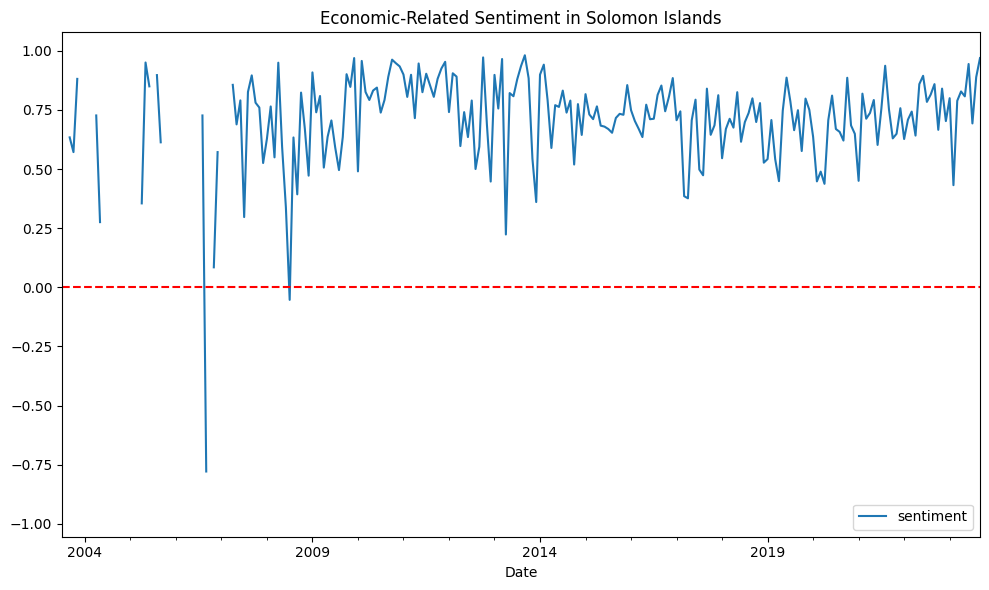

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
sib_econ_sent.plot(x="date", ax=ax);
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Date")
plt.title("Economic-Related Sentiment in Solomon Islands")
plt.tight_layout()

## Embedding Layer + CNN

In [87]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
import string
from nltk.tokenize import word_tokenize

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    news_df["news"],   
    news_df['econ'].astype(int), 
    test_size=0.1, 
    random_state=42,  
    shuffle=True)   

In [125]:
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in spacy_stopwords]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

In [126]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 300
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')


# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.index_to_key:
        embedding_matrix[i] = glove_vectors[word]

# Define the CNN model
model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
386/386 [==============================] - 10s 25ms/step - loss: 0.3060 - accuracy: 0.8748 - val_loss: 0.2592 - val_accuracy: 0.8921
Epoch 2/10
386/386 [==============================] - 10s 25ms/step - loss: 0.2132 - accuracy: 0.9134 - val_loss: 0.2424 - val_accuracy: 0.9103
Epoch 3/10
386/386 [==============================] - 10s 25ms/step - loss: 0.0983 - accuracy: 0.9610 - val_loss: 0.2138 - val_accuracy: 0.9264
Epoch 4/10
386/386 [==============================] - 10s 25ms/step - loss: 0.0244 - accuracy: 0.9922 - val_loss: 0.3204 - val_accuracy: 0.9249
Epoch 5/10
386/386 [==============================] - 10s 25ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.3818 - val_accuracy: 0.9060
Epoch 6/10
386/386 [==============================] - 10s 25ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.4800 - val_accuracy: 0.9344
Epoch 7/10
386/386 [==============================] - 10s 25ms/step - loss: 0.0275 - accuracy: 0.9902 - val_loss: 0.3435 - val_accuracy:

In [127]:
model.evaluate(X_test, y_test)

43/43 [==============================] - 0s 10ms/step - loss: 0.7155 - accuracy: 0.9286


[0.7154676914215088, 0.9285714030265808]